In [86]:
import matplotlib.pyplot as plt
import numpy as np
from uncertainties import ufloat
from uncertainties import unumpy as unp

from spe_funcs import load_data

In [87]:
files = [
    # "data/Energiespektrum-Na22-BaF2-300s.Spe",
    # "data/Energiespektrum-Na22-NaI-328s.Spe",
    "data/Energiespektrum-Co60-BaF2-300s.Spe",
    "data/Energiespektrum-Co60-NaI-263s.Spe"
]

### Choose a file out of the files list to determine the fwhm on

In [88]:
file = files[1]

In [89]:
data, roi = load_data(file, only_roi=False)
roi = np.arange(4150, 5800)
data = data[roi]

In [90]:
data_stds = 0.01*data

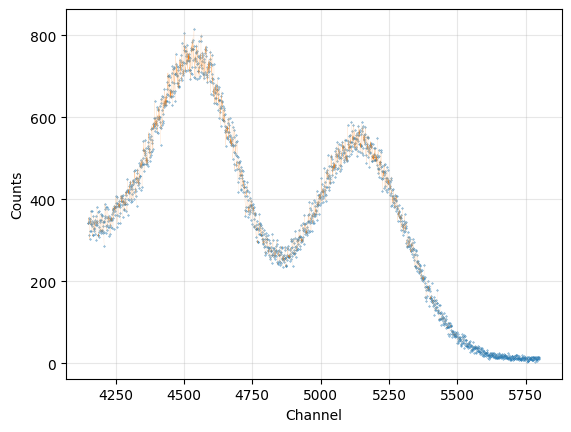

In [91]:
plt.scatter(roi, data, s=0.1)
plt.fill_between(roi, data - data_stds, data + data_stds)
plt.grid(alpha=.3)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.show()

In [92]:
from lmfit.models import GaussianModel, LinearModel

peak = GaussianModel()
peak2 = GaussianModel(prefix='snd')
background = LinearModel()
model = peak + peak2 + background

In [93]:
init_values = {
    'amplitude': {'value': 500, 'min': 0},
    'center': {'value': 4537, 'min': 4250, 'max': 4800},
    'sigma': {'value': 145, 'min': 130, 'max': 160},
    'slope': {'value': -0.1927, 'min': -10, 'max': 0},
    'intercept': {'value': 1108, 'min': 0, 'max': 2000},
    'sndamplitude': {'value': 500, 'min': 0},
    'sndcenter': {'value': 5149, 'min': 4800, 'max': 5500},
    'sndsigma': {'value': 145, 'min': 130, 'max': 160},
}
params = model.make_params(**init_values)
params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude          500        0      inf     None     True     None     None
center            4537     4250     4800     None     True     None     None
fwhm             341.4     -inf      inf     None    False 2.3548200*sigma     None
height           1.376     -inf      inf     None    False 0.3989423*amplitude/max(1e-15, sigma)     None
intercept         1108        0     2000     None     True     None     None
sigma              145      130      160     None     True     None     None
slope          -0.1927      -10        0     None     True     None     None
sndamplitude       500        0      inf     None     True     None     None
sndcenter         5149     4800     5500     None     True     None     None
sndfwhm          341.4     -inf      inf     None    False 2.3548200*sndsigma     None
sndheight        1.376     -inf      inf     None    False 0.3989423*sndamplitude/max(1e-15, sndsigma)   

In [94]:
result = model.fit(data, params, x=list(roi), weights=1.)
result.params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude     1.756e+05        0      inf     1531     True     None     None
center            4539     4250     4800   0.5568     True     None     None
fwhm             326.6     -inf      inf    1.997    False 2.3548200*sigma     None
height           505.2     -inf      inf    2.305    False 0.3989423*amplitude/max(1e-15, sigma)     None
intercept         1169        0     2000    10.75     True     None     None
sigma            138.7      130      160   0.8481     True     None     None
slope          -0.2034      -10        0 0.001968     True     None     None
sndamplitude  1.531e+05        0      inf    995.3     True     None     None
sndcenter         5149     4800     5500   0.6366     True     None     None
sndfwhm          338.6     -inf      inf    1.779    False 2.3548200*sndsigma     None
sndheight        424.7     -inf      inf    1.904    False 0.3989423*sndamplitude/max(1e-15, sndsigma) 

In [95]:
# Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
# amplitude     1.839e+05        0      inf    988.1     True     None     None
# center            4537     4000     5799   0.5229     True     None     None
# fwhm             335.6     -inf      inf    1.523    False 2.3548200*sigma     None
# height           514.8     -inf      inf    1.801    False 0.3989423*amplitude/max(1e-15, sigma)     None
# intercept         1108        0     5000    6.214     True     None     None
# sigma            142.5        0     1000   0.6466     True     None     None
# slope          -0.1927      -10        0 0.001214     True     None     None
# sndamplitude  1.562e+05        0      inf    880.6     True     None     None
# sndcenter         5149     4000     5799   0.6239     True     None     None
# sndfwhm          341.2     -inf      inf    1.718    False 2.3548200*sndsigma     None
# sndheight          430     -inf      inf    1.738    False 0.3989423*sndamplitude/max(1e-15, sndsigma)     None
# sndsigma         144.9        0     1000   0.7295     True     None     None

In [96]:
fitted_params = result.params
x = np.linspace(min(roi), max(roi), 1000)
y = model.eval(x=x, params=fitted_params)

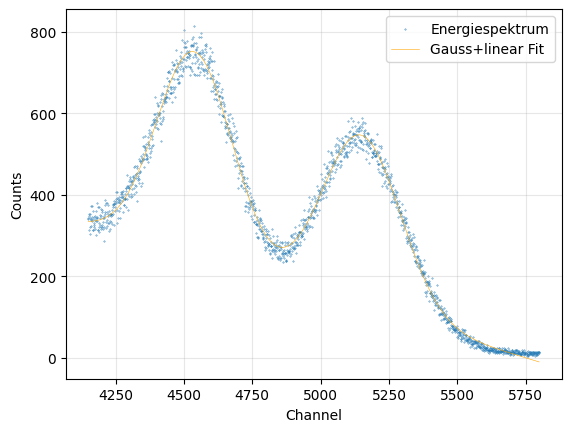

In [97]:
plt.scatter(roi, data, s=0.1, label='Energiespektrum')
plt.plot(x, y, linewidth=.4, c='orange', label='Gauss+linear Fit')
plt.grid(alpha=.3)
plt.legend()
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.show()

In [98]:
params = result.params
centerone = ufloat(params['center'].value, params['center'].stderr)
centertwo = ufloat(params['sndcenter'].value, params['sndcenter'].stderr)
print(centerone)
print(centertwo)
aufloesung = abs((1173.237 - 1332.501) / (centerone - centertwo))
print(f'Aufloesung: {aufloesung} keV/channel')
print(centerone * aufloesung - 1173.237)
print(centertwo * aufloesung - 1332.501)

4538.7+/-0.6
5149.5+/-0.6
Aufloesung: 0.2607+/-0.0004 keV/channel
10.2+/-1.7
10.2+/-1.7


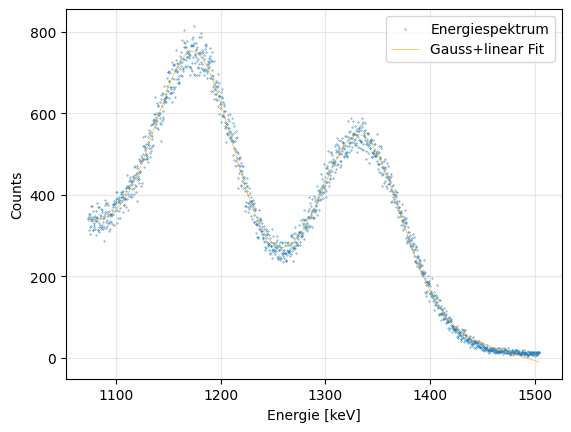

In [99]:
plt.scatter(roi * aufloesung.n - 8.3, data, s=0.1, label='Energiespektrum')
plt.plot(x * aufloesung.n - 8.3, y, linewidth=.4, c='orange', label='Gauss+linear Fit')
plt.grid(alpha=.3)
plt.legend()
plt.xlabel('Energie [keV]')
plt.ylabel('Counts')
plt.show()

In [100]:
print(f'Energieaufloesung für NAI Detektor: {aufloesung} keV/channel')

Energieaufloesung für NAI Detektor: 0.2607+/-0.0004 keV/channel
